In [5]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List
from itertools import product
from tqdm.notebook import tqdm
#!pip install ipywidgets

from celluloid import Camera # getting the camera
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import seaborn as sns
from IPython.display import Video
import os
import pandas as pd

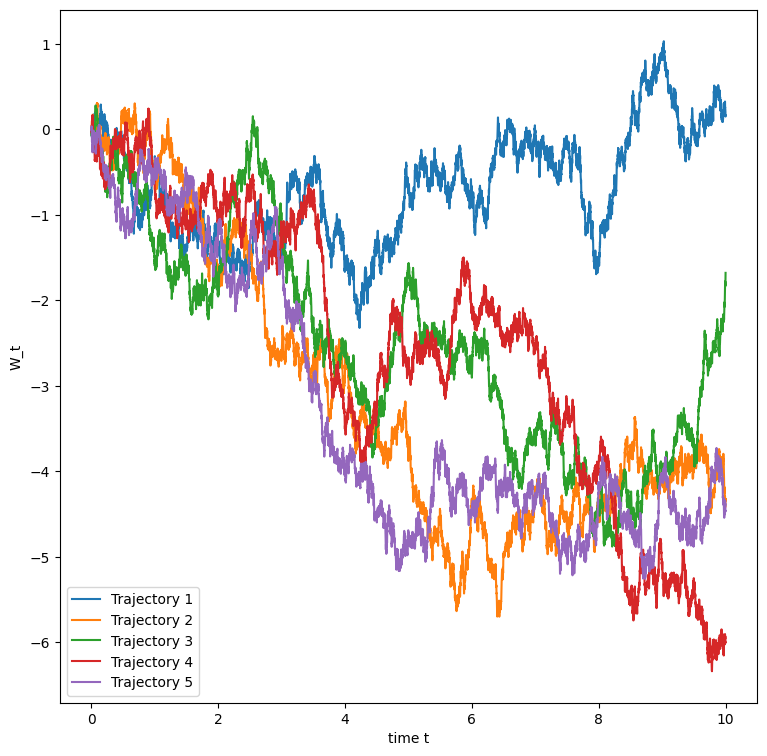

In [9]:
def run_brownian_motion(n_traj: int = 5, n_grid_points: int = 10000, t_start: float = 0.0, t_end: float = 10.0):
    time_grid = np.linspace(t_start,t_end,n_grid_points)
    grid_size = (t_end-t_start)/n_grid_points
    x_0 = np.array([n_traj*[0.0]])
    gaussian_noise = np.random.normal(size=(len(time_grid)-1,n_traj))
    brownian_motion = np.sqrt(grid_size)*gaussian_noise.cumsum(axis=0)
    brownian_motion = np.concatenate([x_0,brownian_motion],axis=0)
    return time_grid,brownian_motion

fig,ax = plt.subplots(figsize=(9,9))
time,X_t = run_brownian_motion()
sample_labels = [f"Trajectory {i}" for i in range(1,6)]
ax.plot(time,X_t,label=sample_labels)
ax.set_xlabel("time t")
ax.set_ylabel("W_t")
ax.legend();

In [10]:
def run_sde(f_determ_drift: Callable,
            g_random_drift: Callable,
            x_start: np.array,
            t_start: float = 0.0, 
            t_end: float = 1.0, 
            n_steps: int = 10000,
            **kwargs):
    """Function to run stochastic differential equation. We assume a deterministic initial distribution p_0."""
    
    #Number of trajectories, dimension of data:
    n_traj,dim_x = x_start.shape

    #Compute time grid for discretization and step size:
    time_grid = np.linspace(t_start,t_end,n_steps)
    step_size = time_grid[1]-time_grid[0]

    #Compute the random drift at every time point:
    random_drift_grid = g_random_drift(time_grid)
    
    #Sample random drift at every time point:
    noise = np.random.normal(size=(n_steps,n_traj,dim_x))
    random_drift_grid_sample = np.sqrt(step_size)*random_drift_grid[:,None,None]*noise
    
    #Initialize list of trajectory:
    x_traj = [x_start]
    
    
    for idx,time in tqdm(enumerate(time_grid)):
        
        #Get last location and time
        x = x_traj[idx]
        t = float(time_grid[idx])
        
        #Get deterministic drift and random drift sample
        determ_drift = step_size*f_determ_drift(x,t)
        random_drift_sample = random_drift_grid_sample[idx]
        
        #Compute next step:
        next_step = x + determ_drift + random_drift_sample
        
        #Save step:
        x_traj.append(next_step)

    return np.stack(x_traj),time_grid    

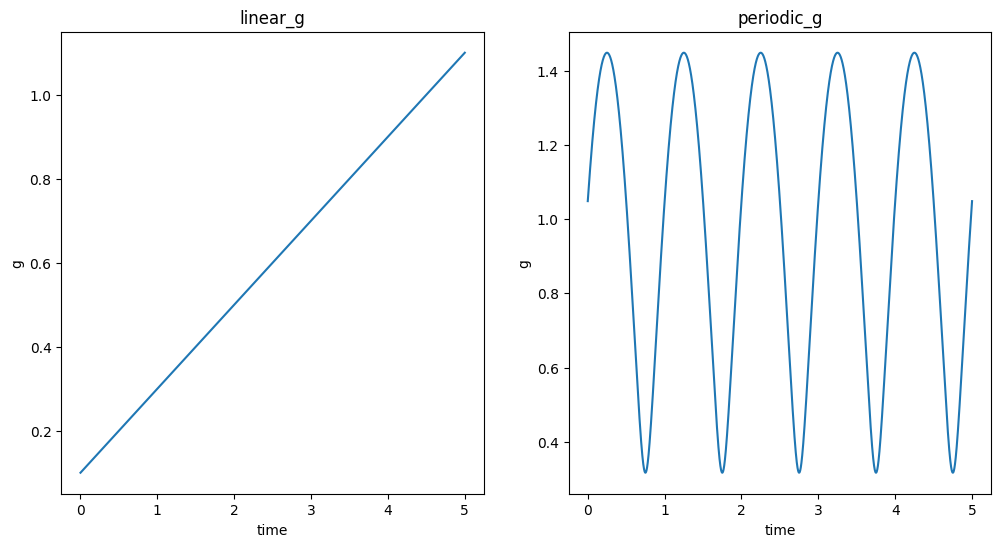

In [11]:
def linear_g(t,constant=0.2):
    """t - 1d np.ndarray or float
    Returns: 1d np.ndarray or float"""
    return 0.1+constant*t

def periodic_g(t):
    """t - 1d np.ndarray or float
    Returns: 1d np.ndarray or float"""
    return np.sqrt(np.sin(2*np.pi*t)+1.10)

def plot_g_random_drift(drift_func_list: List[Callable], min_t: float = 0.0, max_t: float = 5.0,n_grid_points: int = 10000):
    """Function to plot a random drift function g."""
    fig, axs = plt.subplots(1,len(drift_func_list),figsize=(len(drift_func_list)*6,6))
    time = np.linspace(min_t,max_t,n_grid_points)
    for idx,drift_func in enumerate(drift_func_list):
        axs[idx].plot(time,drift_func(time))
        axs[idx].set_title(drift_func.__name__)
        axs[idx].set_xlabel("time")
        axs[idx].set_ylabel("g")

plot_g_random_drift([linear_g,periodic_g])

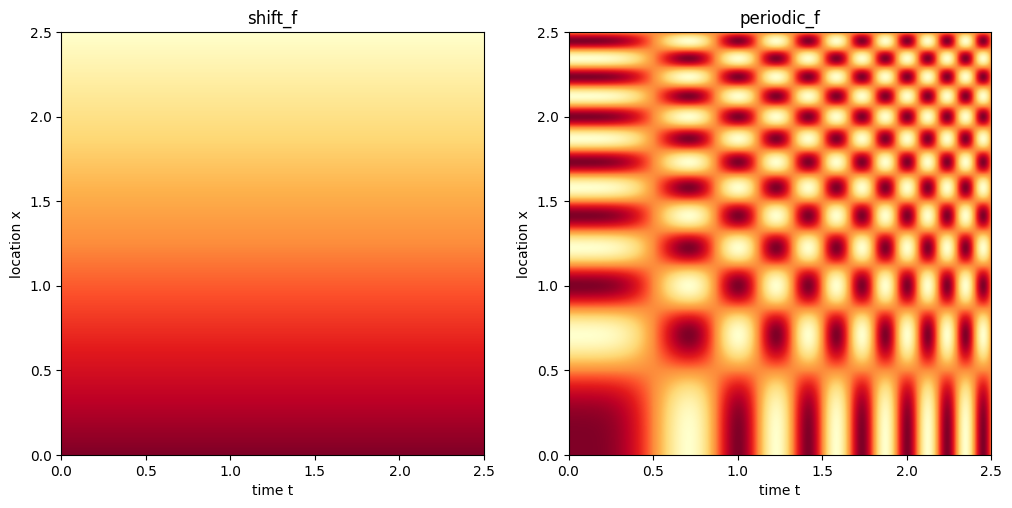

In [13]:
def shift_f(x,t,shift=4.0):
    """x - shape (n,k): a space coefficients 
       t - shape (n) or float: time coefficients"""
    return -(x-shift)

def periodic_f(x,t):
    """x - shape (n,k): space coefficients 
       t - shape (n) or float: time coefficients"""

    if isinstance(t,float):
        return 2*np.cos(2*np.pi*t**2)*(np.cos(2*np.pi*x)) #*normalizer[:,None])
    else:
        return 2*np.cos(2*np.pi*t**2)[:,None]*(np.cos(2*np.pi*x**2)) #*normalizer[:,None])

def plot_f_determ_drift(determ_func_list: List[Callable],
                min_t: float = 0.0, 
                max_t: float = 2.5, 
                min_x: float = 0.0,
                max_x: float = 2.5,
                n_grid_points: int = 1000,
                plot_contours=False):
    """Function to plot the function f(x,t) in an Ito-SDE."""
    time = np.linspace(min_t,max_t,n_grid_points)
    oned_grid = np.linspace(min_x, max_x, n_grid_points)
    twod_grid = np.array([[x,t] for t,x in product(time,oned_grid)])
    extent = [min_x, max_x, min_t, max_t]
    
    fig,axs = plt.subplots(1,len(determ_func_list),figsize=(6*len(determ_func_list),6))
    
    for idx, determ_func in enumerate(determ_func_list):
        derivative = determ_func(twod_grid[:,0].reshape(-1,1),twod_grid[:,1])
        axs[idx].imshow(derivative.reshape(n_grid_points,n_grid_points).transpose(),interpolation='bilinear',origin='lower', extent = extent, cmap=plt.get_cmap('YlOrRd'))
        if plot_contours:
            axs[idx].contour(derivative.reshape(n_grid_points,n_grid_points).transpose(),interpolation='bilinear',origin='lower', extent = extent,color='black')
        axs[idx].set_title(determ_func.__name__)
        axs[idx].set_xlabel("time t")
        axs[idx].set_ylabel("location x")

plot_f_determ_drift([shift_f,periodic_f])

In [14]:
def animate_ito_sde(f_drift: Callable, g_drift: Callable, fpath_anim: str = None, n_steps: int = 100000, n_samples: int = 400,n_grid_points: int = 100, initial_dist:str ="normal", t_end=4.0):
    """Function to animate and plot a 1d SDE over time."""
    if initial_dist == "normal":
        x_start = np.random.normal(size=n_samples).reshape(-1,1)
    elif initial_dist == "uniform":
        x_start = np.random.uniform(size=n_samples).reshape(-1,1)
    else:
        raise ValueError
        
    x_traj,time_grid = run_sde(f_drift,g_drift,x_start=x_start,t_end=t_end,n_steps=n_steps)
    x_traj = x_traj.squeeze()
    
    fig, axs = plt.subplots(3,1,figsize=(24,36))
    camera = Camera(fig)
    
    oned_grid = np.linspace(x_traj.min(), x_traj.max(), len(time_grid))
    twod_grid = np.array([[x,t] for t,x in product(time_grid,oned_grid)])
    extent = [time_grid.min(), time_grid.max(),x_traj.min(), x_traj.max()]
    derivative = f_drift(twod_grid[:,0].reshape(-1,1),twod_grid[:,1])
    derivative_plot = derivative.reshape(len(time_grid),len(time_grid)).transpose()
    
    g_drift_per_time = g_drift(time_grid)

    for idx in tqdm(range(1,len(x_traj),max(int(len(x_traj)/200),1))):
    
        #Plot evolution over time over deterministic drift:
        axs[0].imshow(derivative_plot,interpolation='bilinear',origin='lower', extent = extent, cmap=plt.get_cmap('YlOrRd'),aspect='auto')
        if idx>5:
            for idy in range(10):
                axs[0].plot(time_grid[:idx],x_traj[:idx,idy].squeeze()) #,label=sample_labels)
            axs[0].plot(time_grid[:idx],x_traj[:idx].squeeze().mean(axis=1),color='black',linewidth=10)
        axs[0].set_title("Example trajectories (color=f)")

        #Plot distribution:
        sns.kdeplot(x_traj[idx],ax=axs[1])
        axs[1].set_title("Distribution of X_t")

        #Plot random drift:
        axs[2].plot(time_grid[:idx],g_drift_per_time[:idx])
        axs[2].set_title("Random drift g")
        camera.snap()
        
    animation = camera.animate() # animation ready
    plt.close()
    return animation

In [15]:
RUN_ANIMATION = False
N_STEPS = 1000
N_SAMPLES = 10000

In [16]:
fpath = f"simple_sde.mp4"
animation = animate_ito_sde(shift_f,periodic_g,n_steps=N_STEPS,n_samples=N_SAMPLES)
animation.save(fpath)
HTML(animation.to_html5_video())

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

Converged after 3 iterations.


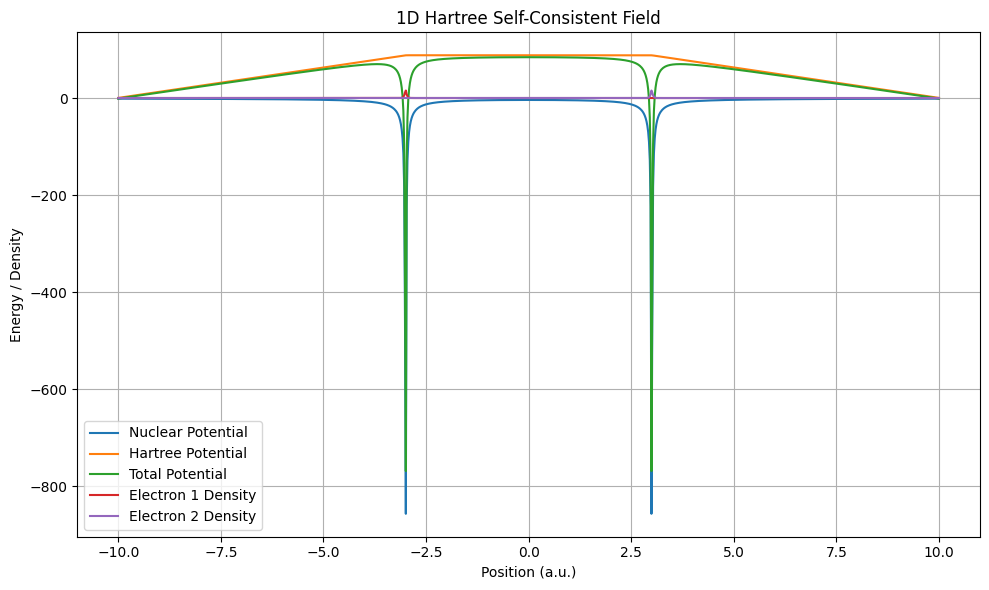

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve, eigs

# -----------------------------
# 参数设置
# -----------------------------
num_electrons = 2
num_nuclei = 2
Z = 6
x_min, x_max = -10, 10
N = 1000
hbar = 1.0  # 原子单位制
m = 1.0

# 网格
dx = (x_max - x_min) / N
x = np.linspace(x_min, x_max, N)

# 原子核位置
nuclei_pos = np.array([-3.0, 3.0])

# -----------------------------
# 原子核势能函数
# -----------------------------
def nuclear_potential(x, nuclei_pos, Z):
    V = np.zeros_like(x)
    for pos in nuclei_pos:
        r = np.abs(x - pos)
        r[r < 1e-3] = 1e-3
        V += -Z / r
    return V

V_nuc = nuclear_potential(x, nuclei_pos, Z)

# -----------------------------
# 初始波函数
# -----------------------------
def init_wavefunctions(x, num_electrons):
    psi = []
    for i in range(num_electrons):
        x0 = x_min + (i+1)*(x_max - x_min)/(num_electrons + 1)
        psi_i = np.exp(-0.5*(x - x0)**2)
        psi_i /= np.sqrt(np.trapz(np.abs(psi_i)**2, dx=dx))
        psi.append(psi_i)
    return psi

psi = init_wavefunctions(x, num_electrons)

# -----------------------------
# 动能算符（有限差分）
# -----------------------------
T = diags([-0.5/dx**2, 1.0/dx**2, -0.5/dx**2], [-1, 0, 1], shape=(N, N)).tocsc()

# -----------------------------
# 自洽场迭代
# -----------------------------
max_iter = 100
threshold = 1e-4
rho_old = np.zeros(N)

for iteration in range(max_iter):
    # 电子密度
    rho = np.zeros(N)
    for psi_i in psi:
        rho += np.abs(psi_i)**2

    # 解泊松方程（Hartree势）
    A = diags([1, -2, 1], [-1, 0, 1], shape=(N, N)).tocsc() / dx**2
    b = -4 * np.pi * rho
    V_h = spsolve(A, b)

    # 总势能
    V_total = V_h + V_nuc

    # 哈密顿量并求解本征值
    H = T + diags(V_total, 0)
    energies, psi_new = eigs(H, k=num_electrons, which='SR')

    # 归一化与更新波函数
    for i in range(num_electrons):
        psi[i] = psi_new[:, i].real
        psi[i] /= np.sqrt(np.trapz(np.abs(psi[i])**2, dx=dx))

    # 收敛性检查
    delta_rho = np.trapz(np.abs(rho - rho_old), dx=dx)
    if delta_rho < threshold:
        print(f"Converged after {iteration} iterations.")
        break
    rho_old = rho.copy()

# -----------------------------
# 可视化结果
# -----------------------------
plt.figure(figsize=(10,6))
plt.plot(x, V_nuc, label='Nuclear Potential')
plt.plot(x, V_h, label='Hartree Potential')
plt.plot(x, V_total, label='Total Potential')
for i in range(num_electrons):
    plt.plot(x, np.abs(psi[i])**2, label=f'Electron {i+1} Density')
plt.legend()
plt.xlabel('Position (a.u.)')
plt.ylabel('Energy / Density')
plt.title('1D Hartree Self-Consistent Field')
plt.grid()
plt.tight_layout()
plt.show()
